In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import networkx as nx
import torch.optim as optim
import torch.nn.functional as F

In [102]:
N=80
g = nx.barabasi_albert_graph(N,1)
A = nx.to_numpy_array(g)

In [14]:
def LV(x,t,A,a,b):
    N = x.shape[0]
    dXdt = np.zeros(N)
    for n in range(0,N):
        dXdt[n] = x[n]*(a[n]-b[n]*x[n])
        for j in range(0,N):
            dXdt[n] -= A[n,j]*x[n]*x[j]
    return dXdt

In [103]:
x0 = np.random.uniform(0,1,N)
T = 5
dt = 0.05
nT = int(T/dt) 
t = np.linspace(0,T,nT)
a = np.random.uniform(0.5,1.5,N)
b = np.random.uniform(0.5,1.5,N)
x = sp.integrate.odeint(LV,x0,t,args=(A,a,b,))
ratio = 0.5
t_obs = T*ratio
nT_obs = int(T*ratio/dt)

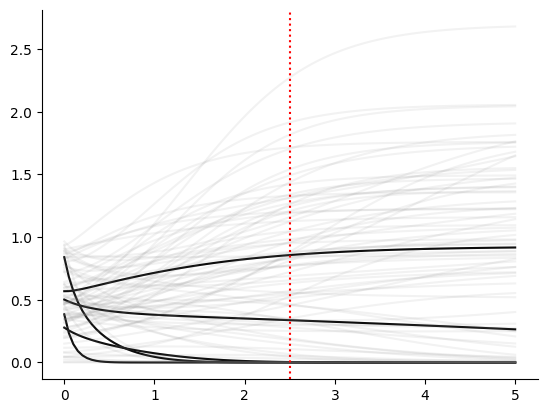

In [104]:
for n in range(0,5):
    plt.plot(t,x[:,n*2],'black')
for n in range(0,N):
    plt.plot(t,x[:,n],'grey',alpha=0.1)
plt.axvline(t_obs,c='red',linestyle=':')
sns.despine()
data = torch.tensor(x[:nT_obs,:], dtype=torch.float32)

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        h, _ = self.lstm(x)
        h = h[:, -1, :]  # Get the last hidden state
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers=1):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, z, seq_len):
        h = self.fc(z).unsqueeze(1).repeat(1, seq_len, 1)
        h, _ = self.lstm(h)
        output = self.output_layer(h)
        return output

In [18]:
class VAE_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim, num_layers=1):
        super(VAE_LSTM, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, num_layers)
        self.decoder = Decoder(latent_dim, hidden_dim, output_dim, num_layers)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z, x.size(1))
        return recon_x, mu, logvar

    def sample(self, z, seq_len):
        return self.decoder(z, seq_len)

In [19]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [114]:
input_dim = 80  # Dimensionality of input time-series
hidden_dim =  100 # Hidden layer dimensionality
latent_dim = 40  # Latent space dimensionality
output_dim = 80  # Output dimensionality (same as input for reconstruction)

In [115]:
model = VAE_LSTM(input_dim, hidden_dim, latent_dim, output_dim, num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [109]:
no_batches = 100
x = np.zeros((no_batches,nT,N))
for s in range(0,no_batches):
    if np.mod(s,10)==0:
        print(s)
    x0 = np.random.uniform(0,1,N)
    x[s,:,:] = sp.integrate.odeint(LV,x0,t,args=(A,a,b,))
x = torch.tensor(x, dtype=torch.float32)

0
10
20
30
40
50
60
70
80
90


In [116]:
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    recon_x, mu, logvar = model(x)
    loss = vae_loss(recon_x, x, mu, logvar)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
decoded_x = recon_x.detach().numpy()
# Sampling from the latent space
#z = torch.randn(32, latent_dim)
#sampled_seq = model.sample(z, seq_len=50)  # Generate new sequences

Epoch 1, Loss: 576359.0
Epoch 2, Loss: 469584.09375
Epoch 3, Loss: 179926.328125
Epoch 4, Loss: 225942.5625
Epoch 5, Loss: 111184.046875
Epoch 6, Loss: 127092.3203125
Epoch 7, Loss: 135084.0
Epoch 8, Loss: 121347.2421875
Epoch 9, Loss: 112209.1484375
Epoch 10, Loss: 110862.609375
Epoch 11, Loss: 109022.71875
Epoch 12, Loss: 104648.234375
Epoch 13, Loss: 100766.734375
Epoch 14, Loss: 100125.703125
Epoch 15, Loss: 100541.5078125
Epoch 16, Loss: 100573.171875
Epoch 17, Loss: 99815.4609375
Epoch 18, Loss: 97809.8984375
Epoch 19, Loss: 95890.8515625
Epoch 20, Loss: 94275.6015625
Epoch 21, Loss: 92623.53125
Epoch 22, Loss: 92266.84375
Epoch 23, Loss: 91461.234375
Epoch 24, Loss: 89996.984375
Epoch 25, Loss: 87950.5703125
Epoch 26, Loss: 86463.1328125
Epoch 27, Loss: 84425.796875
Epoch 28, Loss: 82254.078125
Epoch 29, Loss: 83715.7734375
Epoch 30, Loss: 79843.9453125
Epoch 31, Loss: 84419.5625
Epoch 32, Loss: 77133.0625
Epoch 33, Loss: 79712.21875
Epoch 34, Loss: 73982.3984375
Epoch 35, Loss:

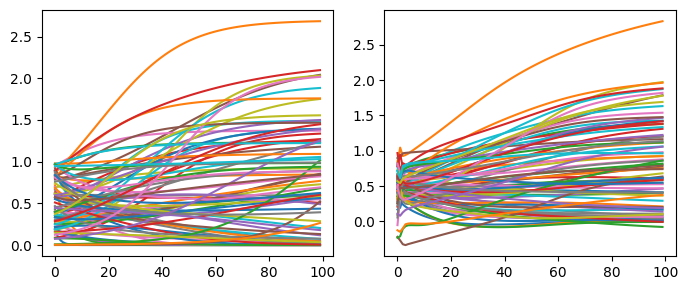

In [117]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(7,3)
ax[0].plot(x[9,:,:])
ax[1].plot(decoded_x[9,:,:])
plt.tight_layout()

In [118]:
z = torch.randn(1, latent_dim)
sampled_seq = model.sample(z, seq_len=nT).detach().numpy().reshape(nT,N)

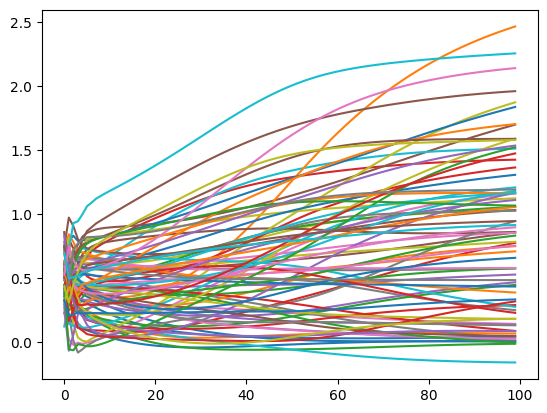

In [119]:
plt.plot(sampled_seq)

In [126]:
encoded = model.encoder(x[0,:,:].reshape(1,100,80))

In [133]:
encoded[1]

tensor([[-5.0082, -0.2357, -0.2172, -0.1847, -0.3152, -0.0721, -0.1389, -0.1483,
         -0.0547, -0.2478, -0.1496, -0.2292, -0.2967, -0.2387, -0.1666, -0.2267,
         -7.0580, -0.3741, -0.2109, -0.1960, -0.1865, -0.3972, -0.2344, -0.3697,
         -0.1793, -0.1160, -0.2335, -0.1143, -4.6908, -0.1252, -0.2648, -0.1188,
         -0.3216, -0.0683, -0.2267, -0.1671, -6.4662, -0.3909, -5.9566, -0.1557]],
       grad_fn=<AddmmBackward0>)

This latent space is static and does not evolve over time